
# resnet18 모델 딥러닝
1. 신경망을 미리 학습한 신경망으로 대체

2. 마지막(완전히 연결된 계층)을 제외한 모든 신경망의 가중치 고정. 마지막 계층은 무작위 가중치를 가지는 것으로 설정해 마지막 계층만 다시 학습

In [1]:
from google.colab import drive 
drive.mount('/gdrive') # 구글드라이브 연결

Mounted at /gdrive


In [2]:
import zipfile as zf
files = zf.ZipFile("/gdrive/My Drive/Colab Notebooks/onlyimagedata.zip",'r') # 압축 파일의 자료 읽기
files.extractall()
files.close()

In [3]:
# 폴더명 기준으로 라벨 구분
import os

labels = os.listdir(r'/content/data') 
print('라벨:', labels)

라벨: ['vin', 'paper', 'styro', 'plastic', 'can', 'pet']


In [4]:
# 각 라벨마다 train, val 파일 생성 및 데이터 나누기(8대2)
!pip install split-folders

import splitfolders

os.mkdir("/content/data_new")
splitfolders.ratio('/content/data', output="/content/data_new", seed=77, ratio=(0.8, 0.2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 60000 files [00:10, 5888.67 files/s]


In [5]:
!pip install torch
!pip install torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy
import numpy as np
import time

cudnn.benchmark = True # 최적의 backend 연산을 찾는 flag를 true 로 설정
plt.ion()   # 대화형 모드
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #오류나는 경우 확인용

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용가능 여부 확인. cuda가 설정되어 있으면 연산을 gpu로 하고, 아니면 cpu로

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
device

device(type='cuda', index=0)

In [8]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체를 train, val 별로 지정
data_transforms = { 
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),# 데이터 증가(augmentation)
        transforms.ToTensor(), # 데이터를 tensor로 바꿔준다. 넘파이는 정수값이 들어있어 오차율 가늠이 힘들고 CIDA 연산도 지원하지 않음
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 정규화(normalization)작업, PyTorch 기본값으로 셋팅
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
data_dir = '/content/data_new' # 이미지 데이터셋에 상단의 transform 내용 적용
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']} 

class_names = image_datasets['train'].classes

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# train과 valid 데이터 개수 확인
print(len(image_datasets['train']), len(image_datasets['val']))

48000 12000


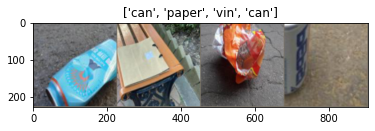

In [11]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    # torch.Tensor를 numpy 객체로 변환
    inp = inp.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    # 이미지 출력
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# 학습 데이터의 배치를 얻기
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만들기
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes]) #  batch size만큼의 image, label 출력

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    global train_losses, train_accu, eval_losses, eval_accu  #

    train_losses=[] #
    train_accu=[] #
    eval_losses=[] #
    eval_accu=[] #

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    if phase == 'train':
      train_losses.append(epoch_loss) #
      train_accu.append(epoch_acc) #
    else:
      eval_losses.append(epoch_loss) #
      eval_accu.append(epoch_acc) #  

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
from torch.optim import lr_scheduler # 미세조정

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 nn.Linear(num_ftrs, len (class_names))로 일반화
model_ft.fc = nn.Linear(num_ftrs, len (class_names)) # 512, 6

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
from torchsummary import summary

summary(model_ft, (3,32,32)) # 모델 정보 확인

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10) # 에폭1당 10분

Epoch 0/9
----------
train Loss: 0.8918 Acc: 0.6916
val Loss: 0.4602 Acc: 0.8444

Epoch 1/9
----------
train Loss: 0.6328 Acc: 0.7829
val Loss: 0.4281 Acc: 0.8624

Epoch 2/9
----------
train Loss: 0.5330 Acc: 0.8147
val Loss: 0.4795 Acc: 0.8337

Epoch 3/9
----------
train Loss: 0.4771 Acc: 0.8319
val Loss: 0.3929 Acc: 0.8667

Epoch 4/9
----------
train Loss: 0.4371 Acc: 0.8452
val Loss: 0.3414 Acc: 0.8789

Epoch 5/9
----------
train Loss: 0.4081 Acc: 0.8546
val Loss: 0.3803 Acc: 0.8729

Epoch 6/9
----------
train Loss: 0.3878 Acc: 0.8623
val Loss: 0.4031 Acc: 0.8585

Epoch 7/9
----------
train Loss: 0.2906 Acc: 0.8954
val Loss: 0.2284 Acc: 0.9223

Epoch 8/9
----------
train Loss: 0.2690 Acc: 0.9036
val Loss: 0.2232 Acc: 0.9254

Epoch 9/9
----------
train Loss: 0.2570 Acc: 0.9069
val Loss: 0.2138 Acc: 0.9276

Training complete in 105m 28s
Best val Acc: 0.927583


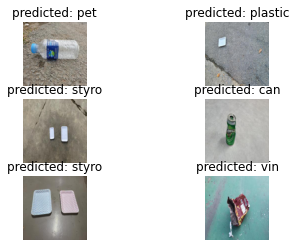

In [17]:
visualize_model(model_ft) # 예측값 시각화 

마지막의 완전히 연결 된 계층을 제외한 모든 신경망의 가중치를 고정. 마지막 계층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습한다.

In [18]:
model_conv = torchvision.models.resnet18(pretrained=True) # 미세 조정, 마지막 계층을 제외한 신경망을 고정 후 다시 돌려보기
for param in model_conv.parameters():
    param.requires_grad = False # 매개변수 고정 후 경사도 계산 안하기

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len (class_names)) # 512, 6

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10) #경사도 계산을 거의 안해도 되므로 시간이 거의 절반으로 줄어든다..그래도 순전파 계산은 해야함

Epoch 0/9
----------
train Loss: 1.1526 Acc: 0.6001
val Loss: 0.7078 Acc: 0.7651

Epoch 1/9
----------
train Loss: 1.1138 Acc: 0.6191
val Loss: 0.8652 Acc: 0.7368

Epoch 2/9
----------
train Loss: 1.1000 Acc: 0.6236
val Loss: 0.9557 Acc: 0.7066

Epoch 3/9
----------
train Loss: 1.1082 Acc: 0.6239
val Loss: 0.9570 Acc: 0.7114

Epoch 4/9
----------
train Loss: 1.1025 Acc: 0.6284
val Loss: 0.7416 Acc: 0.7657

Epoch 5/9
----------
train Loss: 1.0984 Acc: 0.6270
val Loss: 1.0043 Acc: 0.7183

Epoch 6/9
----------
train Loss: 1.1128 Acc: 0.6262
val Loss: 0.7385 Acc: 0.7689

Epoch 7/9
----------
train Loss: 0.9303 Acc: 0.6689
val Loss: 0.6689 Acc: 0.7746

Epoch 8/9
----------
train Loss: 0.9152 Acc: 0.6754
val Loss: 0.6566 Acc: 0.7770

Epoch 9/9
----------
train Loss: 0.9070 Acc: 0.6747
val Loss: 0.6105 Acc: 0.7896

Training complete in 70m 58s
Best val Acc: 0.789583


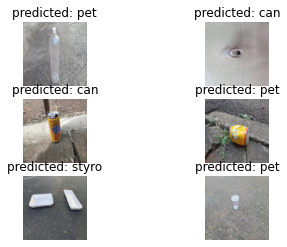

In [20]:
visualize_model(model_conv) # 새 예측값 시각화 

In [28]:
model_path = os.path.join('/content/data_new', str('model_1')+".pth") # 모델저장장
torch.save(model_conv.state_dict(), model_path)